### Author: Стурейко Игорь
### Project: Geekbrains.DataLibraries
### Lesson 6 - Курсовой проект - прогноз цен на квартиры
### Date: 2020-03-27

In [1]:
import warnings

warnings.filterwarnings('ignore')

import datetime # для работы со времнем
import gc # сборщик мусора

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

from lightgbm import LGBMRegressor

%matplotlib inline

# 1. Чтение данных

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                     df[col] = df[col].astype(np.float16)
#                 elif

                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
df = pd.read_csv('./train.csv')
# df = reduce_mem_usage(df)

X = df.drop('Price', axis=1)
y = df[['Price']]

X_final = pd.read_csv('./test.csv')

# сразу создам
preds_final = pd.DataFrame()
preds_final['Id'] = X_final['Id'].copy()

X.set_index('Id', inplace=True)
X_final.set_index('Id', inplace=True)

print('Строк в трейне:' ,  X.shape[0])
print('Строк в тесте', X_final.shape[0])

# Удалим ненужные файлы
# del df
gc.collect()  

Строк в трейне: 10000
Строк в тесте 5000


11

In [4]:
# X.head()

In [5]:
X['DistrictId'] = X['DistrictId'].astype(str)
X_final['DistrictId'] = X_final['DistrictId'].astype(str)

In [6]:
# X.head(2)

### 1.1 Выбросы

In [7]:
X.dtypes

DistrictId        object
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

In [8]:
df_num_features = df.select_dtypes(include='float64')

In [9]:
df_num_features.columns

Index(['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'HouseFloor',
       'Ecology_1', 'Healthcare_1', 'Price'],
      dtype='object')

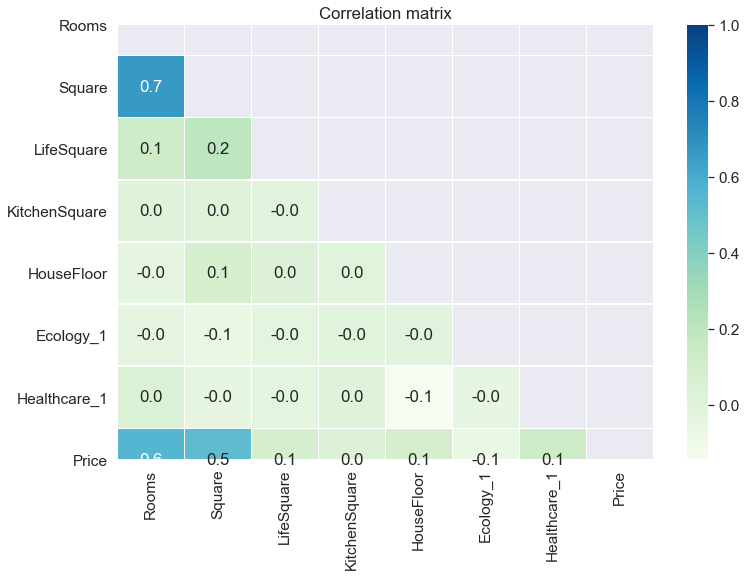

In [10]:
num_features = pd.DataFrame(df_num_features)
corr = num_features.corr()
plt.figure(figsize = (12, 8))
mask = np.zeros_like(corr, dtype=np.bool)  # отрезаем лишнюю половину матрицы
mask[np.triu_indices_from(mask)] = True
sns.set(font_scale=1.4)
sns.heatmap(num_features.corr(), mask=mask, annot=True, fmt='.1f', linewidths=.5, cmap='GnBu')
plt.title('Correlation matrix')
plt.show();

**Rooms**

In [11]:
X['Rooms'].value_counts()

# > 6 комнат, = 0 комнат

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

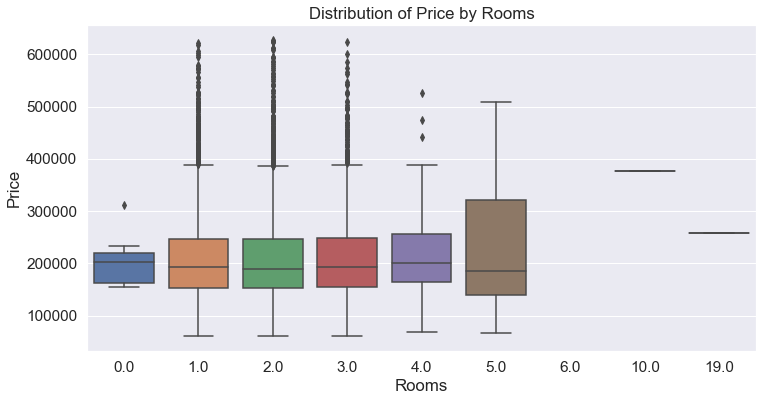

In [12]:
plt.figure(figsize=(12, 6))
sns.boxplot(X['Rooms'], y['Price'])
plt.xlabel('Rooms')
plt.ylabel('Price')
plt.title('Distribution of Price by Rooms')
plt.show();

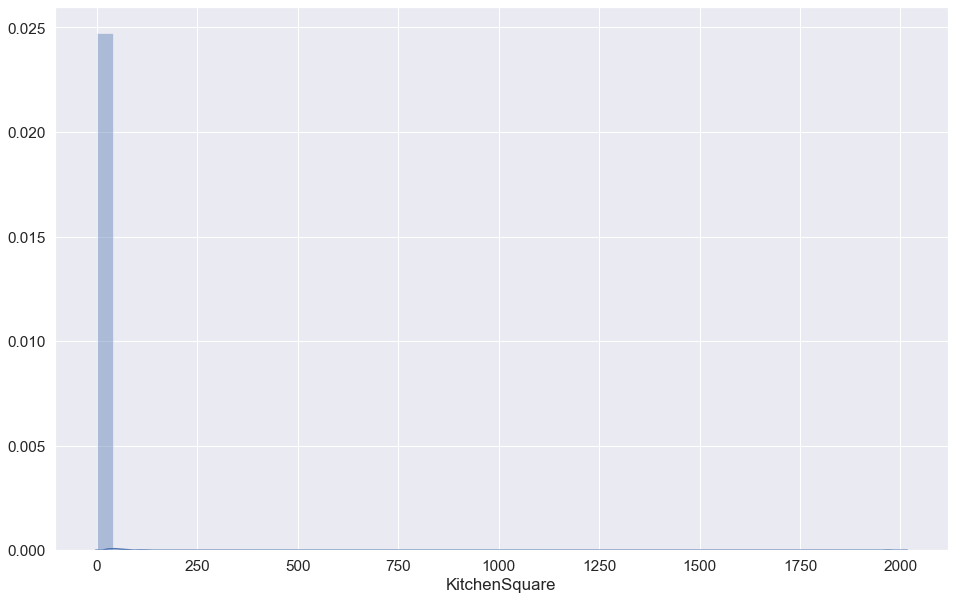

In [13]:
plt.figure(figsize=(16,10))
sns.distplot(X['KitchenSquare'])
plt.show()

In [14]:
X['KitchenSquare'].value_counts().sort_values()

# Площадь < 3
# Площадь > 1000

54.0         1
72.0         1
96.0         1
66.0         1
48.0         1
40.0         1
2014.0       1
35.0         1
60.0         1
78.0         1
27.0         1
84.0         1
42.0         1
62.0         1
39.0         1
1970.0       1
36.0         1
75.0         1
26.0         1
21.0         1
29.0         1
23.0         1
73.0         1
123.0        1
31.0         1
63.0         1
53.0         1
30.0         2
58.0         2
32.0         2
51.0         2
43.0         2
25.0         2
112.0        2
41.0         2
37.0         2
22.0         3
2.0          4
18.0         6
19.0        11
17.0        12
20.0        14
16.0        16
3.0         22
15.0        31
4.0         39
14.0        51
13.0        67
11.0       233
12.0       249
7.0        609
0.0        697
9.0        843
6.0       1038
10.0      1075
5.0       1169
8.0       1306
1.0       2460
Name: KitchenSquare, dtype: int64

**Floor, HouseFloor**

In [15]:
X['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [16]:
X['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42])

In [17]:
(X['Floor'] > X['HouseFloor']).sum()

1825

**HouseYear**

In [18]:
X['HouseYear'].sort_values().unique()

array([    1910,     1912,     1914,     1916,     1917,     1918,
           1919,     1928,     1929,     1930,     1931,     1932,
           1933,     1934,     1935,     1936,     1937,     1938,
           1939,     1940,     1941,     1942,     1947,     1948,
           1950,     1951,     1952,     1953,     1954,     1955,
           1956,     1957,     1958,     1959,     1960,     1961,
           1962,     1963,     1964,     1965,     1966,     1967,
           1968,     1969,     1970,     1971,     1972,     1973,
           1974,     1975,     1976,     1977,     1978,     1979,
           1980,     1981,     1982,     1983,     1984,     1985,
           1986,     1987,     1988,     1989,     1990,     1991,
           1992,     1993,     1994,     1995,     1996,     1997,
           1998,     1999,     2000,     2001,     2002,     2003,
           2004,     2005,     2006,     2007,     2008,     2009,
           2010,     2011,     2012,     2013,     2014,     2

In [19]:
X.loc[X['HouseYear'] == 20052011, 'HouseYear'] = 2007

In [20]:
X.loc[X['HouseYear'] == 4968, 'HouseYear'] = 1968

In [21]:
X['HouseYear'].value_counts()

1977    2652
2017     308
2016     305
2015     299
2014     210
        ... 
1914       1
1947       1
1910       1
1928       1
1916       1
Name: HouseYear, Length: 95, dtype: int64

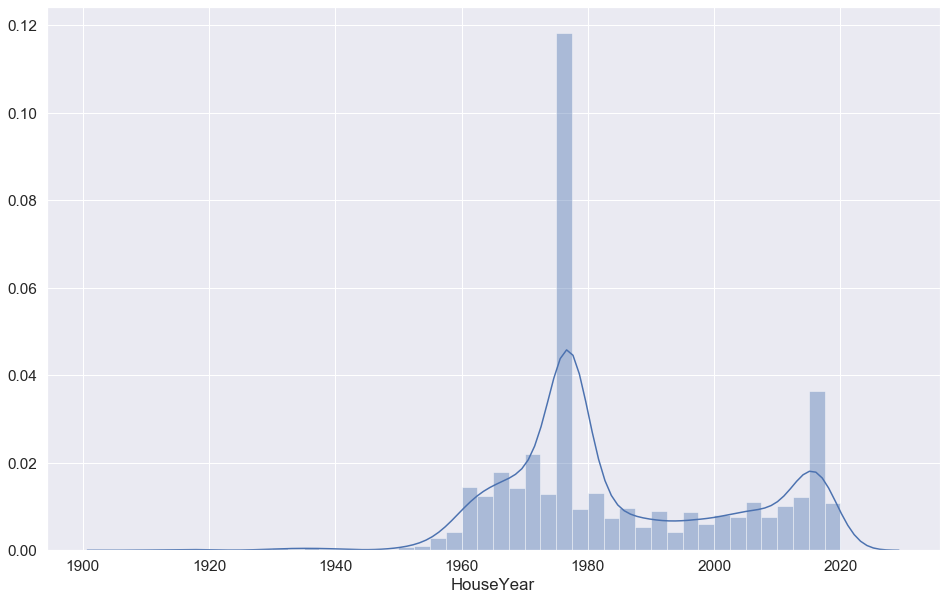

In [22]:
plt.figure(figsize=(16,10))
sns.distplot(X['HouseYear'])
plt.show()

In [23]:
X[X['HouseYear'] > 2020].head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,


In [24]:
(X['HouseYear'] // 1000).unique()

array([1, 2])

In [25]:
X['HouseYear'].sort_values().unique() // 100 - X['HouseYear'].sort_values().unique() // 1000*10

array([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0])

In [26]:
# X.loc[(X['HouseYear'] // 1000 > 2) & 
#       (X['HouseYear'] // 1000 < 10) &
#       (X['HouseYear'] // 100 - X['HouseYear'] // 1000*10 < 3),
#       'HouseYear'] = ((X.loc[(X['HouseYear'] // 1000 > 2) & 
#       (X['HouseYear'] // 1000 < 10) &
#       (X['HouseYear'] // 100 - X['HouseYear'] // 1000*10),
#       'HouseYear']) % 1000) + 1000

# X.loc[(X['HouseYear'] // 1000 > 2) & 
#       (X['HouseYear'] // 1000 < 10) &
#       (X['HouseYear'] // 100 - X['HouseYear'] // 1000*10 > 3),
#       'HouseYear'] = ((X.loc[(X['HouseYear'] // 1000 > 2) & 
#       (X['HouseYear'] // 1000 < 10) &
#       (X['HouseYear'] // 100 - X['HouseYear'] // 1000*10),
#       'HouseYear']) % 1000) + 2000

In [27]:
X.loc[(X['HouseYear'] // 1000) > 2, 'HouseYear']

Series([], Name: HouseYear, dtype: int64)

In [28]:
X['Shops_1'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 15, 16, 19, 23])

In [29]:
X['Shops_1'].value_counts()

0     2316
1     1325
5     1324
2      964
4      841
3      711
6      487
11     401
9      316
7      294
8      253
23     245
10     215
15     176
16      83
19      49
Name: Shops_1, dtype: int64

### Заполнение NaN

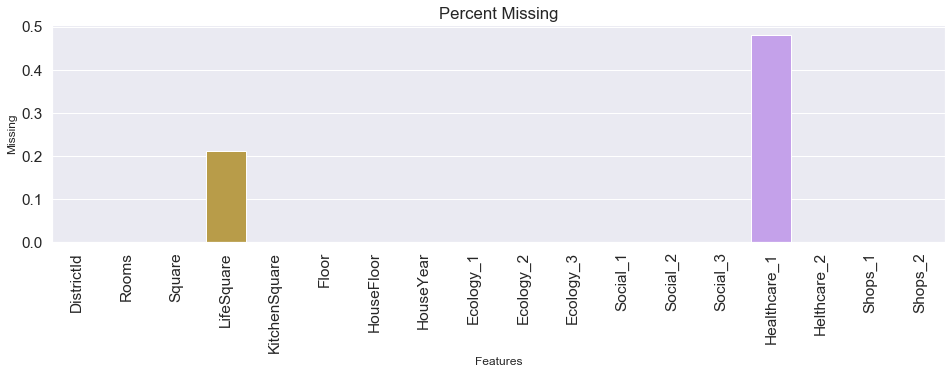

In [30]:
import seaborn as sns

nan_df = (X.isna().sum() / X.shape[0]).reset_index()
nan_df.columns=['feature', 'nan_percent']

plt.figure(figsize=(16,4))
sns.barplot(nan_df['feature'], nan_df['nan_percent'])
plt.title('Percent Missing')
plt.ylabel('Missing', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=90)
plt.show()

# Удалим Healthcare_1
# Заполним LifeSquare

### 1.2 Feature engineering

**DistrictId**

In [31]:
X.DistrictId.nunique()

205

In [32]:
dict(X['DistrictId'].value_counts())

{'27': 851,
 '1': 652,
 '23': 565,
 '6': 511,
 '9': 294,
 '62': 247,
 '30': 228,
 '58': 179,
 '53': 174,
 '21': 165,
 '52': 143,
 '8': 142,
 '11': 129,
 '46': 119,
 '61': 118,
 '45': 116,
 '74': 114,
 '34': 111,
 '57': 107,
 '44': 104,
 '47': 97,
 '101': 97,
 '13': 97,
 '99': 97,
 '7': 92,
 '48': 90,
 '94': 89,
 '29': 89,
 '41': 87,
 '3': 82,
 '84': 80,
 '28': 79,
 '2': 78,
 '22': 78,
 '25': 77,
 '85': 76,
 '93': 73,
 '90': 72,
 '37': 72,
 '96': 71,
 '59': 67,
 '75': 66,
 '26': 65,
 '12': 64,
 '128': 64,
 '88': 64,
 '66': 62,
 '67': 61,
 '17': 59,
 '55': 58,
 '39': 57,
 '10': 56,
 '105': 55,
 '31': 55,
 '18': 51,
 '119': 49,
 '111': 49,
 '0': 48,
 '78': 46,
 '91': 44,
 '63': 43,
 '124': 43,
 '129': 43,
 '79': 42,
 '42': 42,
 '109': 41,
 '113': 41,
 '77': 40,
 '54': 37,
 '38': 36,
 '15': 36,
 '24': 35,
 '5': 34,
 '32': 34,
 '56': 34,
 '103': 33,
 '123': 32,
 '80': 31,
 '33': 31,
 '19': 31,
 '83': 31,
 '69': 29,
 '130': 29,
 '138': 29,
 '64': 28,
 '86': 27,
 '108': 27,
 '87': 27,
 '70': 

# 2. Очистка данных

In [33]:
def zeroRooms(ds):
    """Обработка числа комнат"""
    # Когда 0 - смотрим квартиру с похожей площадью, вычисляем для них среднее количество комнат 
    # и их записываем вместо 0
    ds['Rooms_outlier'] = 0
#     ds.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
    for s in ds.loc[ds['Rooms'] < 1, 'Square'].values:
#         print('\nSquare: ' + str(s) + ':')
        nm = 0
        con = 0
        for d in ds.loc[(ds['Square'] < s*1.1) & (ds['Square'] > s*0.9), 'Rooms'].values:
            nm += d
            con += 1
#         print('Похожих квартир: ' + str(con))
#         print ('Среднее количество комнат: ' + str(np.round(nm / con, 0)))
        ds.loc[(ds['Rooms'] == 0) & (ds['Square'] == s), 'Rooms_outlier'] = 1
        ds.loc[(ds['Rooms'] == 0) & (ds['Square'] == s), 'Rooms'] = np.round(nm / con, 0)
    
    ds.loc[ds['Rooms'] == 0, 'Rooms'] = 1
    medians = ds.median()
    # в случае когда комнат больше 6 заменяем на медиану
    ds.loc[ds['Rooms'] >= 6, 'Rooms'] = medians['Rooms'] # !!! медиана посчитана на трейне !!!

In [34]:
def processingKitchenValue(ds):
#     ds.loc[(ds['KitchenSquare'] < 3) & (ds['Square'] < 40), 'KitchenSquare'] = 4
#     ds.loc[(ds['KitchenSquare'] < 3) & (ds['Square'] >= 40) & (ds['Square'] <= 60), 'KitchenSquare'] = 8
#     ds.loc[(ds['KitchenSquare'] < 3) & (ds['Square'] > 60), 'KitchenSquare'] = 12
    ds.loc[ds['KitchenSquare'] < 3, 'KitchenSquare'] = 3
    ds.loc[ds['KitchenSquare'] > 100, 'KitchenSquare'] = ds.loc[ds['KitchenSquare'] > 100, 'KitchenSquare'] / 10  # можно median
        

In [35]:
class FeatureImputer:
    """Заполнение пропусков и обработка выбросов"""
    
    def __init__(self):
        self.medians=None
        
    def fit(self, X):
        self.medians = X.median()
    
    def transform(self, X):
        
        # Rooms
#         X['Rooms_outlier'] = 0
#         X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
#         X.loc[X['Rooms'] == 0, 'Rooms'] = 1
#         X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms'] # !!! медиана посчитана на трейне !!!
        # Обработка количества комнат.
        zeroRooms(X)
        
        # KitchenSquare
        processingKitchenValue(X)
#         X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
#         X.loc[X['KitchenSquare'] > 1000, 'KitchenSquare'] = X.loc[X['KitchenSquare'] > 1000, 'KitchenSquare'] / 10  # можно median
        
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] = X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor']
        
        # HouseYear
        current_year = now = datetime.datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = self.medians['HouseYear']
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        
        condition = (X['LifeSquare'].isna()) &\
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        
        return X
        

In [36]:
imputer = FeatureImputer()

imputer.fit(X) # расчет медиан

X = imputer.transform(X)
X_final = imputer.transform(X_final)

# 3. Feature engineering

In [37]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # DistrictID
        district = X['DistrictId'].value_counts()
        district = district[district > 50]  ## Если вы этого не сделаете, то на Leaderboard-е улетите в самый низ (>100 места, R2 ~ 0.65),
                                            ## Хотя на локальной валидации скор вырастет
        
        self.DistrictId_counts = dict(district)
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # Target encoding
        ## District
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            df['DistrictId_popular'] = df['DistrictId'].copy()
            df.loc[~df['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
            
            self.med_price_by_district = df.groupby(['DistrictId_popular', 'Rooms'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByDistrict',
                                                           'DistrictId_popular': 'DistrictId'})
            
        ## floor, year
        if y is not None:
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
        

        
    def transform(self, X):
        
        # DistrictId
        X['DistrictId_count'] = X['DistrictId'].map(self.DistrictId_counts)  # self.DistrictId_counts = {'id': value}
        
        X['new_district'] = 0
        X.loc[X['DistrictId_count'].isna(), 'new_district'] = 1
        
        X['DistrictId_count'].fillna(5, inplace=True)
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец flooar_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
        
        return X
    
    @staticmethod
    def floor_to_cat(X):
        
        X['floor_cat'] = np.nan
        
        X.loc[X['Floor'] < 3, 'floor_cat'] = 1  
        X.loc[(X['Floor'] >= 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
        X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
        X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
        X.loc[X['Floor'] > 15, 'floor_cat'] = 5
            
        return X
     
    @staticmethod
    def year_to_cat(X):
        
        X['year_cat'] = np.nan
        
        X.loc[X['HouseYear'] < 1941, 'year_cat'] = 1
        X.loc[(X['HouseYear'] >= 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
        X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
        X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
        X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
        X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6
            
        return X
            
    

In [38]:
features = FeatureGenetator()

features.fit(X, y)

X = features.transform(X)
X_final = features.transform(X_final)


In [39]:
# Удаляю, просто чтобы было быстрее строить модель. Возможно, вам стоит что-то сделать с не количественными признаками
remain_features = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'Ecology_1', 'Social_1', 'Shops_1',
                  'Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan',
                   'HouseFloor', 'HouseYear',
                   
                  'DistrictId_count', 'new_district', 'Ecology_2', 'Ecology_3', 'Shops_2',
                  'MedPriceByDistrict',
                  'MedPriceByFloorYear']

X = X[remain_features]
X_final = X_final[remain_features]

# 4. Модель

### Оптимизация параметров

In [40]:
# model = LGBMRegressor(random_state=42)

In [41]:
# params = {'n_estimators':[50, 100, 200, 400],
#          'max_depth':[5, 10, 15, 20, 25, 30],
#          'min_samples_leaf': [5, 7, 10, 12, 15, 20]}

# gs = GridSearchCV(model, 
#                   params, 
#                   scoring='r2',
#                   cv=KFold(n_splits=5, # к (количество разбиений) в кросс-валидации
#                            random_state=21, 
#                            shuffle=True),
#                   n_jobs=-1) # -1 - будет считать на всех доступных потоках
# gs.fit(X, y)

# gs.best_params_

In [42]:
model = LGBMRegressor(max_depth=20,
                             min_samples_leaf=5,
                             n_estimators=200,
                             random_state=42)

cv_score = cross_val_score(model, X, y, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

R2: 0.735 +- 0.019


In [43]:
# Обучаю модель на всем трейне
model.fit(X, y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=20,
              min_child_samples=20, min_child_weight=0.001, min_samples_leaf=5,
              min_split_gain=0.0, n_estimators=200, n_jobs=-1, num_leaves=31,
              objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

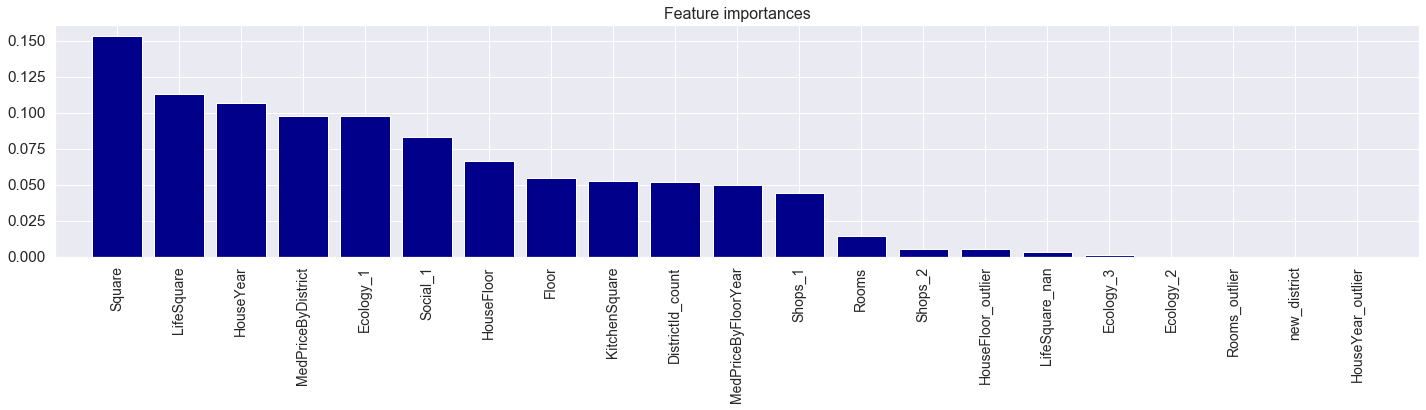

In [44]:
def plot_feature_importances(importances, X):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    # plt.savefig('fe.jpg')
    plt.show()
    
plot_feature_importances(importances = model.feature_importances_, X=X)

In [45]:
y_pred_final = model.predict(X_final)

preds_final['Price'] = y_pred_final
# preds_final.to_csv('predictions_7_year.csv', index=False)

preds_final.head()

,Id,Price
0,725,158720.358510
1,15856,249989.405667
2,5480,188704.635501
3,15664,302334.927782
4,14275,142586.528896


In [46]:
print('R2: {:.3f} +- {:.3f}'.format(mean, std))

R2: 0.735 +- 0.019


R2: 0.737 +- 0.019